## Trabajo practico 2 Criticas 

Grupo 6

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, make_scorer)
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
np.random.seed(1)
tf.random.set_seed(1) 
from sklearn.preprocessing import StandardScaler

import nltk
import string

import warnings
warnings.filterwarnings("ignore")

Cargamos nuestro dataframe

In [3]:
df_train = pd.read_csv('train.csv')

Analisis y preprocesamiento

In [4]:
df_train.head(5)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [5]:
df_train.dtypes

ID              int64
review_es      object
sentimiento    object
dtype: object

Pasamos los obejects a string 

Verificamos si el dataset tiene datos faltantes

In [6]:
datos_faltantes = df_train.isnull().sum()
print(datos_faltantes)

ID             0
review_es      0
sentimiento    0
dtype: int64


Observamos la distibucion de nustro target

In [7]:
df_train['sentimiento'].value_counts()

sentimiento
positivo    25000
negativo    25000
Name: count, dtype: int64

Realizamos un bag of words para poder utilizar los modelos

## PREPROCESAMIENTO

In [8]:
# Con nltk vamos a pasar a lowercase, tokenizar y extraer palabras conectoras del dataset.
def nltk_preprocess(text):
    global stop_words
    text = text.replace('.', '. ')
    text = text.lower()
    tokens = text.split()
    tokens = [word.strip(string.punctuation) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [9]:
#Primero, pasamos todo a minusculas.
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Franl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df_train["review_es"] = df_train["review_es"].apply(lambda x: nltk_preprocess(x))
df_train['review_es'] = df_train['review_es'].astype('string')
df_train['sentimiento'] = df_train['sentimiento'].astype('string')

In [11]:
# Creamos una variable con el sentimiento
# Convertimos a binaria
df_train['sentimiento_1'] = np.where(df_train['sentimiento'] == 'positivo', 1, 0)

In [12]:
df_copy_id = df_train['ID']
df_train.drop(columns = (['sentimiento','ID']))

,review_es,sentimiento_1
0,críticos mencionado después ver solo 1 oz epis...,1
1,pequeña pequeña producción técnica filmación i...,1
2,pensé manera maravillosa pasar tiempo fin sema...,1
3,básicamente familia niño pequeño jake piensa z...,0
4,amor tiempo petter mattei película visualmente...,1
...,...,...
49995,pensé película hizo buen trabajo derecha tan c...,1
49996,mala parcela mal diálogo mala actuación direcc...,0
49997,católica enseñada escuelas primarias parroquia...,0
49998,voy tener desacuerdo comentario anterior lado ...,0


## Bayes Naive

Dividimos nuestro Dataset en un conjunto de train y otro de test

In [13]:
#Creo un dataset con los features que voy a usar para clasificar
df_train_x = df_train['review_es']

#Creo un dataset con la variable target
df_train_y = df_train['sentimiento_1'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_train_x, 
                                                    df_train_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2,
                                                    stratify=df_train_y.values) #semilla

Creamos una funcion para mostrar nuestras metricas

In [14]:
def metricas(y_pred,y_test):

  print(classification_report(y_pred,y_test))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

Creamos nuestro modelo de bayes primero sin optimizar los hiper parametos

In [15]:
#Creamos nuestro modelo
Bayes_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
#Entrenamos
Bayes_model.fit(x_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [16]:
#Predecimos
y_pred_bayes = Bayes_model.predict(x_test)

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      7546
           1       0.85      0.85      0.85      7454

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



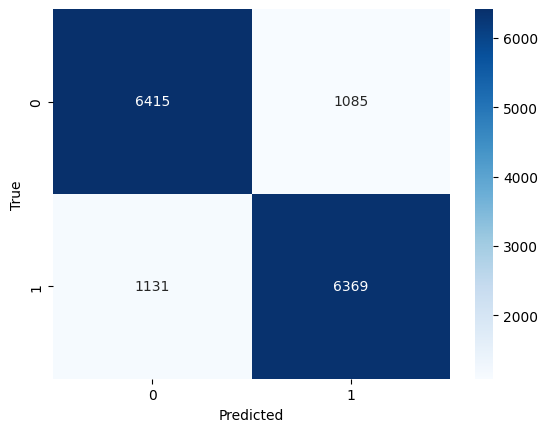

In [17]:
#Mostramos las metricas
metricas(y_pred_bayes,y_test)

Realizamos las busqueda de hiper parametros

In [ ]:
#Realizamos un TfidVectorizer para pasar tokenizar nuestras criticas
pipe = make_pipeline(TfidfVectorizer(), MultinomialNB()) #Usamos un make_pipe para pasarle la entrada al segundo modelo

param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],  # Uni-gram or bi-gram
    'multinomialnb__alpha': [0.1, 0.5, 1.0],  # Smoothing parameter
}

# Grid search
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
display(best_params)
display(best_score)

In [50]:
nb_model_h = make_pipeline(TfidfVectorizer(ngram_range =(1, 2)), MultinomialNB(alpha = 0.2))


In [51]:
#Entrenamos el modelo
nb_model_h.fit(x_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('multinomialnb', MultinomialNB(alpha=0.2))])

In [52]:
y_pred_h = nb_model_h.predict(x_test)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7456
           1       0.88      0.88      0.88      7544

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



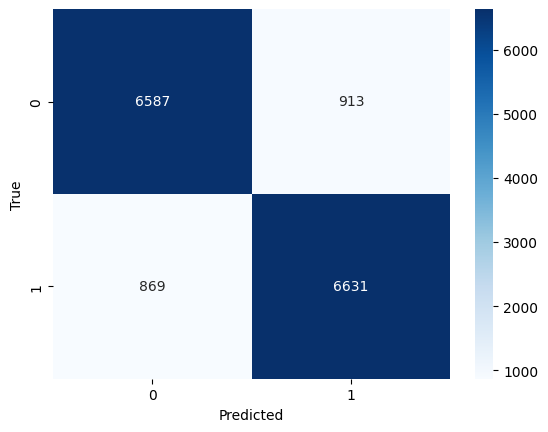

In [22]:
metricas(y_pred_h,y_test)

## Xg-boost

Creamos el modelo primero sin mejorar sus hiper parametros

In [23]:
import xgboost as xg_boost
xg_model = make_pipeline(TfidfVectorizer(), xg_boost.XGBClassifier())

In [ ]:
xg_model.fit(x_train,y_train) #Entrenamos el modelo
y_pred_Xg = xg_model.predict(x_test) #Realizamos el predict

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      7085
           1       0.86      0.82      0.84      7915

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



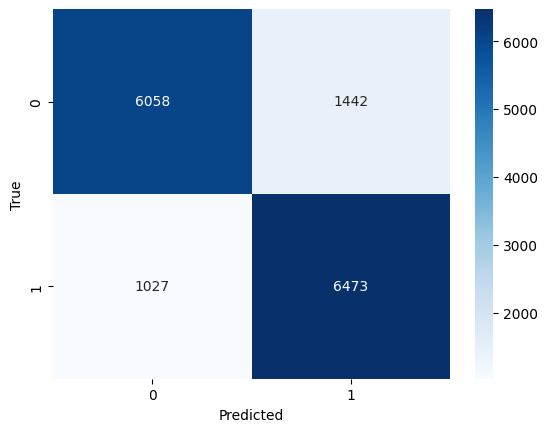

In [ ]:
metricas(y_pred_Xg,y_test)

Ahora buscamos los mejores hiper parametros para nuestro modelo

In [ ]:

import xgboost as xg_boost

pipe = make_pipeline(TfidfVectorizer(), xg_boost.XGBClassifier())

param_grid = {
    'xgbclassifier__max_depth': [10,15,20],  # Maximum depth of trees
    'xgbclassifier__learning_rate': [0.3,1,0.5],  # Learning rate
    'xgbclassifier__n_estimators': [250,300,350]  # Number of trees (boosting rounds)
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
display(best_params)
display(best_score)


"\nimport xgboost as xg_boost\n\npipe = make_pipeline(TfidfVectorizer(), xg_boost.XGBClassifier())\n\nparam_grid = {\n    'xgbclassifier__max_depth': [10,15,20,25],  # Maximum depth of trees\n    'xgbclassifier__learning_rate': [0.3,1,0.5,2],  # Learning rate\n    'xgbclassifier__n_estimators': [250,300,350,400]  # Number of trees (boosting rounds)\n}\n\ngrid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')\ngrid_search.fit(x_train, y_train)\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\ndisplay(best_params)\ndisplay(best_score)\n"

Probamos los mejores hiper parametros que encontramos

In [40]:
import xgboost as xg_boost
xg_model_H = make_pipeline(TfidfVectorizer(ngram_range =(1, 2)), xg_boost.XGBClassifier(n_estimators = 350 ,learning_rate = 0.2, max_depth = 7))

In [41]:
xg_model_H.fit(x_train,y_train) #Entrenamos el modelo
y_pred_Xg_H = xg_model_H.predict(x_test) #Realizamos el predict

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      7388
           1       0.86      0.85      0.86      7612

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



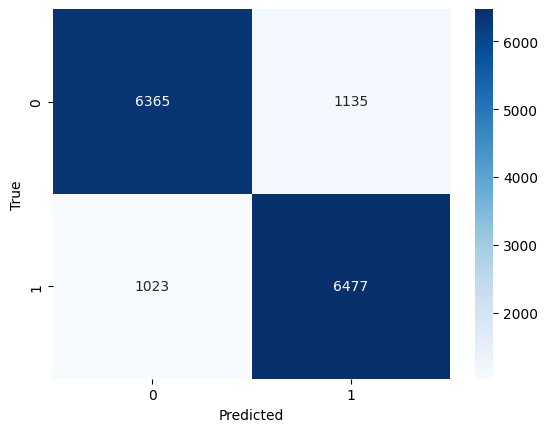

In [42]:
#Mostramos nuestras metricas
metricas(y_pred_Xg,y_test)

## Random Forest

Primero creamos nuestro modelo de Random forest sin optmizar hiper parametros

In [ ]:
#Creamos el modelo
R_f = make_pipeline(TfidfVectorizer(), RandomForestClassifier()) #Tokenizamos el texto

In [ ]:
#Entrenamos el modelo
R_f.fit(x_train,y_train)

In [ ]:
y_pred_R_M = R_f.predict(x_test)

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      7697
           1       0.83      0.85      0.84      7303

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



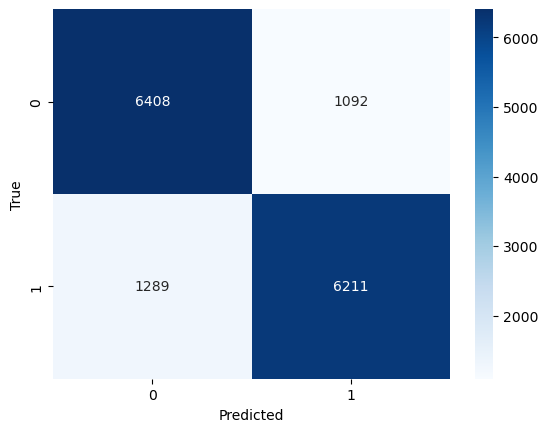

In [ ]:
metricas(y_pred_R_M,y_test)

Buscamos los mejores hiper parametros para nuestro modelo

In [ ]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

param_grid = {
    'randomforestclassifiern_estimators': [250,300,400,500],  # Estimadores
    'randomforestclassifiermax_depth': [40,50,60,70],  # Maxima profundidad
    'randomforestclassifier__min_samples_split': [5,20,30,40]

}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')
grid_search.fit(x_train, y_train)
best_params = grid_search.bestparams
best_score = grid_search.bestscore
display(best_params)
display(best_score)

Creamos un modelo con los mejores hiper parametros obtenidos

In [28]:
R_f_H = make_pipeline(TfidfVectorizer(ngram_range =(1, 2)), RandomForestClassifier(max_depth= 70, min_samples_split = 20,n_estimators =400))

In [29]:
#Entrenamos el modelo
R_f_H.fit(x_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=70, min_samples_split=20,
                                        n_estimators=400))])

In [30]:
#Realizamos el predict
y_pred_R_f_H = R_f_H.predict(x_test) 

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      7257
           1       0.88      0.85      0.86      7743

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



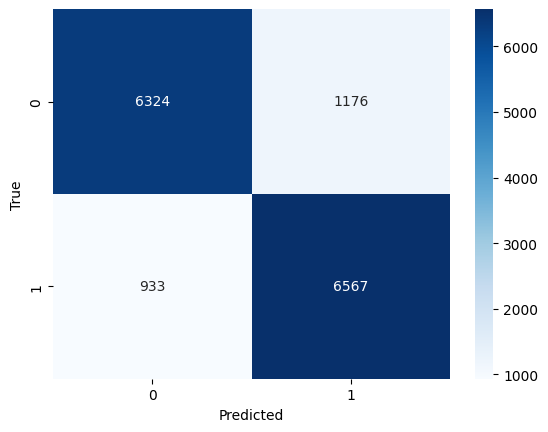

In [31]:
metricas(y_pred_R_f_H,y_test)

## Voting

Utilizamos voting como ensamble elegido

In [48]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      7366
           1       0.89      0.87      0.88      7634

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



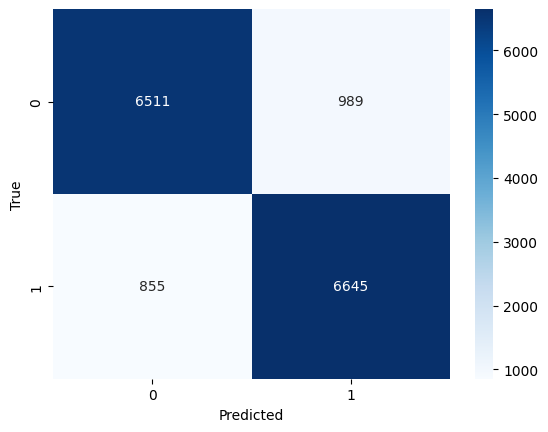

In [53]:
#Creo clasificadores
nb_clf = nb_model_h
xgb_H_clf = xg_model_H
rnd_clf = R_f_H


#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('xgb', xgb_H_clf), ('rnd', rnd_clf), ('nb', nb_clf)], voting = 'hard')

#Armo conjunto entrenamiento y test 70-30
x_train_Vt, x_test_Vt, y_train_Vt, y_test_Vt = train_test_split(df_train_x, 
                                                    df_train_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2,
                                                    stratify=df_train_y.values)


#Entreno el ensemble
vot_clf.fit(x_train_Vt, y_train_Vt)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test_Vt)
metricas(pred,y_test_Vt)

## Red Neuronal

In [13]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
#Creo un dataset con los features que voy a usar para clasificar
df_train_x = df_train['review_es']

#Creo un dataset con la variable target
df_train_y = df_train['sentimiento_1'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_train_x, 
                                                    df_train_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2,
                                                    stratify=df_train_y.values) #semilla

In [110]:
# Tokenizar los datos de texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index) + 1

# Convertir los textos en secuencias numéricas
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Asegurarse de que todas las secuencias tengan la misma longitud
max_seq_length = max(len(seq) for seq in x_train_seq)
x_train_seq = pad_sequences(x_train_seq, maxlen=max_seq_length)
x_test_seq = pad_sequences(x_test_seq, maxlen=max_seq_length)

Buscamos los mejores hiperparametros

In [16]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Definimos una funcion para crear e modelo
def create_model(epochs=1, num_units=64, learning_rate=0.001):
    model = keras.Sequential([
            layers.Embedding(vocab_size, 100, input_length=max_seq_length),
            layers.Conv1D(128, 5, activation='relu'),
            layers.GlobalMaxPooling1D(),
            layers.Dense(num_units, activation='relu'),
            layers.Dense(1, activation='sigmoid')
    ])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision()])
    return model

# Creamos un KerasClassifier con scikit-learn
model = KerasClassifier(build_fn=create_model, batch_size=16)

# Def H-params
param_grid = {
    'epochs': [3],
    'num_units': [64,128,32],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_result = grid_search.fit(x_train_seq, y_train)

# Usamos los mejores hiper params 
best_params = grid_result.best_params_
best_model = grid_result.best_estimator_



2188/2188 [==============================] - 1717s 783ms/step - loss: 0.3588 - accuracy: 0.8340 - precision: 0.8385


In [17]:
print(best_params)

{'epochs': 1, 'learning_rate': 0.001, 'num_units': 32}


469/469 [==============================] - 63s 134ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      7500
           1       0.88      0.89      0.88      7500

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



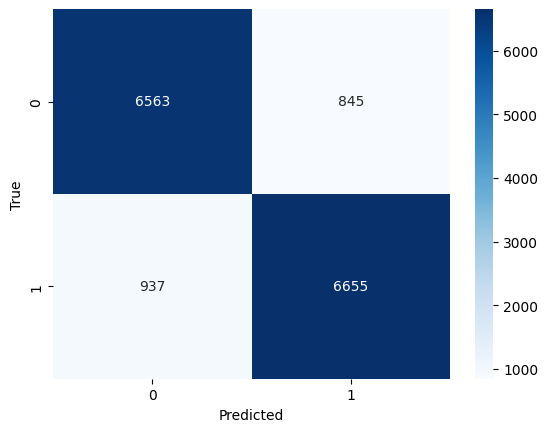

In [18]:
y_predic_ = best_model.predict(x_test_seq)
y_predic_cat = np.where(y_predic_>0.4,1,0) #Seteamos un corte en los datos para determinar si cancelo o no 

ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index() #Armamos un dataset
ds_validacion.columns=['y_pred','y_real'] #Nombramos las columnas

metricas(ds_validacion.y_pred,ds_validacion.y_real) #Dividimos el dataset

Una vez obtenidos y probados los hiper parametros construimos nuestra nueva red mejorada

In [20]:
# Convertir los textos en secuencias numéricas
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index) + 1

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

max_seq_length = max(len(seq) for seq in x_train_seq)
x_train_seq = pad_sequences(x_train_seq, maxlen=max_seq_length)
x_test_seq = pad_sequences(x_test_seq, maxlen=max_seq_length)

# Construyo el modelo de red neuronal
model_rn = keras.Sequential([
    layers.Embedding(vocab_size, 100, input_length=max_seq_length),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilamos y entrenamos el modelo
model_rn.compile(keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision()])
fit_model = model_rn.fit(x_train_seq, y_train, epochs=1, batch_size=16, validation_data=(x_test_seq, y_test))

2813/2813 [==============================] - 1717s 610ms/step - loss: 0.3429 - accuracy: 0.8450 - precision_1: 0.8391 - val_loss: 0.2765 - val_accuracy: 0.8850 - val_precision_1: 0.8750


157/157 [==============================] - 22s 140ms/step
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2500
           1       0.87      0.91      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



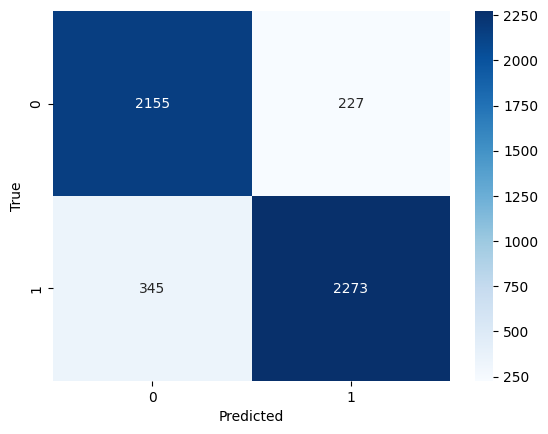

In [21]:
y_predic_ = model_rn.predict(x_test_seq)
y_predic_cat = np.where(y_predic_>0.471,1,0) #Seteamos un corte en los datos para determinar si cancelo o no 

ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index() #Armamos un dataset
ds_validacion.columns=['y_pred','y_real'] #Nombramos las columnas

metricas(ds_validacion.y_pred,ds_validacion.y_real) #Dividimos el dataset

## Tratamiento de variables antes del submit

In [32]:
df_test = pd.read_csv('test.csv')
df_copy_id_test = df_test['ID'] #copio el id y lo quito del dataframe
df_test.drop(['ID'], axis='columns', inplace=True)
df_test.head(5)

,review_es
0,La mayor virtud de esta película es su existen...
1,"No soy un experto cinéfilo, pero pocas veces m..."
2,Si no eres un incondicional del humor estilo T...
3,"No sé qué está pasando, si la gente se deja ll..."
4,"Pero cuando amanece,y me quedo solo,siento en ..."


In [33]:
#Paso los objects a strings y reviso los datos faltantes
df_test['review_es'] = df_test['review_es'].astype('string')
datos_faltantes_test = df_test.isnull().sum()
print(datos_faltantes_test)

review_es    0
dtype: int64


In [34]:
df_test['review_es'].value_counts()

review_es
La mayor virtud de esta película es su existen...    1
Pocos fenómenos tan llamativos como esta modes...    1
No sé qué está pasando, si la gente se deja ll...    1
Pero cuando amanece,y me quedo solo,siento en ...    1
La llegada de Rafa a Euskadi es como ponerse a...    1
                                                    ..
Me esperaba mucho, pero que mucho, más.Guión m...    1
De mal cuerpo como sensación al finalizar, de ...    1
Los que han añadido comentarios os lo han dich...    1
Dirigida por Alberto Rodríguez ("Grupo 7"), el...    1
Fui a ver esta película de cine con entusiasmo...    1
Name: count, Length: 8599, dtype: Int64

In [35]:
df_test["review_es"] = df_test["review_es"].apply(lambda x: nltk_preprocess(x))
df_test['review_es'] = df_test['review_es'].astype('string')

## Submits

Bayes-naive

In [32]:
y_submi = nb_model_h.predict(df_test['review_es'])

In [33]:
df_submit_test = pd.DataFrame({'ID': df_copy_id_test,'sentimiento':y_submi})
df_submit_test['sentimiento'] = np.where(df_submit_test['sentimiento'] == 1, 'positivo', 'negativo')

df_submit_test.to_csv('Submit_test.csv',index = False)

Xg-Boost

In [46]:
y_submit_xg_h = xg_model.predict(df_test['review_es'])


In [47]:
df_submit_test = pd.DataFrame({'ID': df_copy_id_test,'sentimiento':y_submit_xg_h})
df_submit_test['sentimiento'] = np.where(df_submit_test['sentimiento'] == 1, 'positivo', 'negativo')

df_submit_test.to_csv('Submit_test_Xg.csv',index = False)

Random-Forest

In [36]:
y_submit_R_f_H = R_f_H.predict(df_test['review_es'])

In [37]:
df_submit_test = pd.DataFrame({'ID': df_copy_id_test,'sentimiento':y_submit_R_f_H})
df_submit_test['sentimiento'] = np.where(df_submit_test['sentimiento'] == 1, 'positivo', 'negativo')

df_submit_test.to_csv('Submit_test_Rm.csv',index = False)

Voting

In [54]:
y_submit_vtg = vot_clf.predict(df_test['review_es'])

In [55]:
df_submit_test = pd.DataFrame({'ID': df_copy_id_test,'sentimiento':y_submit_vtg})
df_submit_test['sentimiento'] = np.where(df_submit_test['sentimiento'] == 1, 'positivo', 'negativo')

df_submit_test.to_csv('Submit_test_Vtg.csv',index = False)

Red neuronal

In [116]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_test['review_es'])
vocab_size = len(tokenizer.word_index) + 1

# Convertir los textos en secuencias numéricas
df_test_seq = tokenizer.texts_to_sequences(df_test['review_es'])
#x_test_seq = tokenizer.texts_to_sequences(x_test)

# Asegurarse de que todas las secuencias tengan la misma longitud
max_seq_length = max(len(seq) for seq in df_test_seq)
df_test_seq = pad_sequences(df_test_seq, maxlen=max_seq_length)
#x_test_seq = pad_sequences(x_test_seq, maxlen=max_seq_length)

In [117]:
y_submit_rn = model_rn.predict(df_test_seq)
y_submit_rn_cat = np.where(y_submit_rn>0.471,1,0) 

269/269 [==============================] - 11s 39ms/step


In [120]:
df_submit_test = pd.DataFrame({'ID': df_copy_id_test,'sentimiento':y_submit_rn_cat.flatten()})
df_submit_test['sentimiento'] = np.where(df_submit_test['sentimiento'] == 1, 'positivo', 'negativo')

df_submit_test.to_csv('Submit_test_Rn.csv',index = False)